# Imports e inicialización del servidor

In [42]:
import mysql.connector
import os, getpass, re, requests
import gensim
import pandas as pd
import numpy as np
import cvxpy as cp
import tensorflow as tf
import matplotlib.pyplot as plt
from mysql.connector import Error
from itertools import combinations
from ast import literal_eval
from collections import defaultdict
from scipy.spatial import distance
from sklearn.manifold import TSNE
from bs4 import BeautifulSoup
import plotly.graph_objects as go
K = 10

In [2]:
def cosine_similarity(A, b):
    # Definición de los argumentos de la similaridad coseno
    A_dot_b = np.sum(A * b, axis=1)
    A_norm = np.sqrt(np.sum(A ** 2, axis=1))
    b_norm = np.sqrt(np.sum(b ** 2))
    return A_dot_b / (A_norm * b_norm)

# Cargando los datos

In [17]:
data = np.load('Summary/training_data.npz', allow_pickle=True)
Y_data = data['Y_data']
Y_data = [i.lower() for i in Y_data]
Y_data

['angelica',
 'savoy cabbage',
 'silver linden',
 'kiwi',
 'allium',
 'garden onion',
 'leek',
 'garlic',
 'chives',
 'lemon verbena',
 'cashew nut',
 'pineapple',
 'dill',
 'custard apple',
 'wild celery',
 'peanut',
 'burdock',
 'horseradish',
 'tarragon',
 'mugwort',
 'asparagus',
 'oat',
 'star fruit',
 'brazil nut',
 'common beet',
 'borage',
 'chinese mustard',
 'swede',
 'rape',
 'common cabbage',
 'cauliflower',
 'brussel sprouts',
 'kohlrabi',
 'broccoli',
 'chinese cabbage',
 'turnip',
 'pigeon pea',
 'tea',
 'capers',
 'pepper',
 'papaya',
 'safflower',
 'caraway',
 'pecan nut',
 'chestnut',
 'roman camomile',
 'chickpea',
 'endive',
 'chicory',
 'chinese cinnamon',
 'ceylon cinnamon',
 'watermelon',
 'lime',
 'lemon',
 'pummelo',
 'mandarin orange (clementine, tangerine)',
 'sweet orange',
 'coffee',
 'arabica coffee',
 'robusta coffee',
 'coriander',
 'common hazelnut',
 'saffron',
 'muskmelon',
 'cucumber',
 'cucurbita',
 'cumin',
 'turmeric',
 'quince',
 'lemon grass',
 

# Abriendo el modelo GloVe entrenado en Wikipedia

In [5]:
# Cargando el embedding en memoria
embeddings_index = dict()
with open('C:/Users/Chris-Brota/Desktop/glove.6b/glove.6B.100d.txt', 'r', encoding='utf8') as file:
    for line in file:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

print(f'Vector de {len(embeddings_index)} palabras cargadas.')

Vector de 400001 palabras cargadas.


In [6]:
print(embeddings_index.get('citric'))

[ 0.28123   0.19583   0.06453  -0.13524   0.99726  -0.19329  -0.48548
  0.43083  -0.16015  -0.12496  -0.5319    0.57561  -0.5881    0.085808
 -0.0859    0.75721  -1.1515   -0.084785  0.65576   0.064682  0.067194
 -1.1096    0.92557   0.57395  -0.34474   0.37906  -0.82575  -0.55303
 -0.58417   0.044774  0.76227   0.75636  -0.45388  -0.8378   -0.39259
 -0.3134    0.29243   0.025914  1.0914   -0.13309   0.57329  -0.12037
 -0.90361  -0.91887   1.013     1.276    -0.31055  -0.86031  -0.45764
 -0.35792  -0.34129  -0.64878  -0.21554  -0.32376  -0.75714   0.80563
 -1.143     0.128    -0.34669  -0.40518  -0.031299 -0.63768  -0.35624
 -0.28367   0.73029  -0.47432   0.84953  -1.1061    0.046679 -1.1738
 -0.4851    0.45272   0.16722   0.35547  -0.27191  -0.26114   0.21498
 -0.79119  -0.75023  -0.63608   0.068707 -0.46095  -0.44356   0.52749
 -0.32422   0.77409  -0.81332   0.1544   -0.40902   0.4267   -0.59445
 -0.10446  -1.2722   -0.76292   0.6785   -0.43202  -0.19278  -0.26015
  0.93397   0.54029

# Checkeo de las palabras objetivo

In [18]:
not_found = []
found = []

for food_i in Y_data:
    if len(food_i.split()) == 1:
        if embeddings_index.get(food_i) is None:
            not_found.append(food_i)
        else:
            found.append(food_i)

In [58]:
len(found)

357

# Matriz de Embedding de términos objetivo

In [19]:
# create a weight matrix for words in training docs
embedding_matrix = list()
embedding_words = list()
for word in found:
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix.append(embedding_vector)
        embedding_words.append(word)

embedding_matrix = np.array(embedding_matrix)

# Testing: Buscando las palabras próximas

In [57]:
def find_Nprox_words(terms_to_rev, N_words, metric='euclidean'):
    # Definición del diccionario de palabras
    word_dict_out = dict()

    for term in terms_to_rev:
        # Definición del vector de embedding
        embed_term = embeddings_index.get(term)

        if embed_term is None: continue
        
        if metric == 'euclidean':
            # Diferencia cuadrática
            dif_metric = np.sum((embedding_matrix - embed_term) ** 2, axis=1)
            reverse_sort = False
        
        elif metric == 'cosine':
            # Similaridad coseno
            dif_metric = (cosine_similarity(embedding_matrix, embed_term) + 1) / 2
            reverse_sort = True
        
        # Etiquetando posición
        pos_dif = [(i, delta) for i, delta in enumerate(dif_metric)]

        # Ordenando
        pos_dif.sort(key=lambda x: x[1], reverse=reverse_sort)

        # Agregar al diccionario
        word_dict_out[term] = [(embedding_words[i[0]], i[0], i[1]) for i in pos_dif[1:1+N_words]]

    return word_dict_out


def find_Nprox_words_joint(terms_to_rev, N_words, metric='euclidean'):
    # Definición del diccionario de palabras
    word_dict_out = dict()
    
    # Definición de un vector de embedding total
    embed_total = list()
    
    for term in terms_to_rev:
        # Definición del vector de embedding
        embed_term = embeddings_index.get(term)

        if embed_term is None: continue
        else: embed_total.append(embed_term)    
        
    # Calculando la media del vector embebido
    embed_total = np.array(embed_total).mean(axis=0)
    
    if metric == 'euclidean':
        # Diferencia cuadrática
        dif_metric = np.sum((embedding_matrix - embed_total) ** 2, axis=1)
        reverse_sort = False

    elif metric == 'cosine':
        # Similaridad coseno
        dif_metric = (cosine_similarity(embedding_matrix, embed_total) + 1) / 2
        reverse_sort = True

    # Etiquetando posición
    pos_dif = [(i, delta) for i, delta in enumerate(dif_metric)]

    # Ordenando
    pos_dif.sort(key=lambda x: x[1], reverse=reverse_sort)

    # Agregar al diccionario
    word_dict_out[' '.join(terms_to_rev)] = [(embedding_words[i[0]], i[0], i[1]) for i in pos_dif[1:1+N_words]]

    return word_dict_out


terms_to_rev = ['citric', 'fruit']
N_words = 30
a = find_Nprox_words_joint(terms_to_rev, N_words, metric='cosine')['citric fruit']

for i in a:
    print((i[0], f'{round(i[2] * 100, 2)}%'))

('syrup', '82.77%')
('citrus', '82.58%')
('grape', '81.75%')
('mango', '81.31%')
('corn', '81.14%')
('sugar', '81.05%')
('honey', '80.24%')
('coconut', '79.97%')
('coffee', '79.66%')
('barley', '79.64%')
('lemon', '79.12%')
('vinegar', '79.07%')
('pear', '78.74%')
('cream', '77.48%')
('lime', '77.44%')
('pectin', '77.33%')
('banana', '77.06%')
('grapefruit', '77.02%')
('vanilla', '77.01%')
('tea', '76.37%')
('pomegranate', '75.97%')
('watermelon', '75.94%')
('pineapple', '75.82%')
('papaya', '75.6%')
('beer', '75.57%')
('wheat', '75.46%')
('avocado', '75.45%')
('lettuce', '75.4%')
('peach', '75.25%')
('beverages', '75.06%')


# Visualizando con T-SNE

In [29]:
word_vectors = np.array([embeddings_index[word] for word in embedding_words])
print('Word Embedding shapes:', word_vectors.shape)

Word Embedding shapes: (357, 100)


In [32]:
tsne = TSNE(n_components=2, random_state=0, n_iter=10000, perplexity=3)
T_words = tsne.fit_transform(word_vectors)
labels = embedding_words

<IPython.core.display.Javascript object>


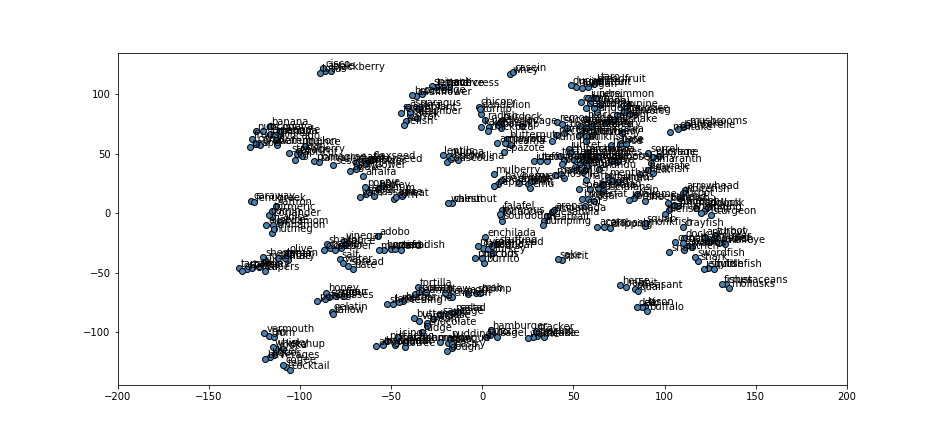

In [41]:
%matplotlib inline
plt.figure(figsize=(19, 15))
plt.scatter(T_words[:, 0], T_words[:, 1], c='steelblue', edgecolors='k')
for label, x, y in zip(labels, T_words[:, 0], T_words[:, 1]):
    plt.annotate(label, xy=(x+1, y+1), xytext=(0, 0), textcoords='offset points')
    
plt.xlim([-200,200])
plt.show()

In [51]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=T_words[:, 0],
                         y=T_words[:, 1],
                         text=labels,
                         textposition='top center',
                         mode='markers+text'))
fig.update_traces(textfont_size=8)
fig.update_layout(title='Análisis de alimentos objetivos FooDB: TSNE sobre Word Embeddings')
fig.write_html('Results/TSNE_GloVe_embeddings.html')
fig.show()